In [1]:
import pandas as pd
import numpy as np
import json
from itertools import chain
import os
import cvxpy as cp
import matplotlib.pyplot as plt
from copy import deepcopy

from preprocessing_utils import ScaleData, SplitData, n_lag_return, LogReturn2SimpleReturn
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

In [2]:
def GetResultsFromJSON(ticker, fold, exp_dir):
    result_dir = f"{exp_dir}/fold{fold}/{ticker}/model_results.json"
    with open(result_dir, 'r') as f:
        results = json.load(f)
    return results

def FetchBestResults(results):
    best_idx = np.argmin(results['val_losses'])
    best_results = {key: value[best_idx] for key, value in results.items()}
    return best_results

In [3]:
stock_tickers = pd.read_csv('data/SP500_tickers_clean.csv', header=0).Ticker.unique()
stock_data = pd.read_csv('data/SP500_stock_prices_log_clean_3monthreturn.csv', index_col=0, parse_dates=True)

In [4]:
TEST_SPLITS = ['2018-10-01', 
               '2019-01-01', 
               '2019-04-01', 
               '2019-07-01', 
               '2019-10-01']


In [5]:
# initialize another df with the same index and ticker column as stock_data
optimal_weights = pd.DataFrame(stock_data['Ticker'][stock_data.index >= TEST_SPLITS[4]]).groupby('Ticker').head(63)
optimal_weights.head(2), optimal_weights.tail(2)

(           Ticker
 Date             
 2019-10-01    MMM
 2019-10-02    MMM,
            Ticker
 Date             
 2019-12-27    ZTS
 2019-12-30    ZTS)

In [6]:
# get the experiment names
exp_path = 'experiments/'
exp_names = os.listdir(exp_path)
exp_names

['exp_cycl_1dh',
 'exp_cycl_1dH',
 'exp_cycl_1Dh',
 'exp_cycl_1DH',
 'exp_plat_2Dh',
 'exp_plat_2dh',
 'exp_plat_2DH',
 'exp_cycl_2Dh',
 'exp_cycl_2dH',
 'exp_cycl_2DH',
 'exp_cycl_2dh',
 'exp_plat_1DH',
 'exp_plat_1Dh',
 'exp_plat_1dH',
 'exp_plat_1dh']

In [7]:
pred_index_df = pd.DataFrame(index=stock_data.index[stock_data.index >= TEST_SPLITS[4]].unique()).iloc[:63]
pred_index_df

""
Date
2019-10-01
2019-10-02
2019-10-03
2019-10-04
2019-10-07
...
2019-12-23
2019-12-24
2019-12-26


In [8]:
# Empty list to store each ticker's results as a series
mean_list = {}
std_list = {}

# for exp_name in exp_names[0:2]:

for ticker in stock_tickers:
    exp_dir = os.path.join(exp_path, 'exp_cycl_1dh')
    results = GetResultsFromJSON(ticker, 4, exp_dir)
    BestResults = FetchBestResults(results) # val_means is 63 long, so for each day we find the best tickers

    mean_list[ticker] = LogReturn2SimpleReturn(BestResults['val_means'])
    std_list[ticker] = LogReturn2SimpleReturn(BestResults['val_stds'])

pred_mean_df = pd.DataFrame(mean_list, index=pred_index_df.index)
pred_std_df = pd.DataFrame(std_list, index=pred_index_df.index)

pred_mean_df

,MMM,AOS,ABT,ABBV,ACN,ATVI,ADM,ADBE,ADP,AAP,...,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2019-10-01,-0.157729,-0.123192,-0.132743,0.533031,-0.254938,0.132266,0.252078,-0.230365,0.063081,-0.189044,...,-0.074614,0.038610,-0.288303,0.247696,0.064413,0.328081,-0.178221,-0.179099,-0.077243,0.100320
2019-10-02,-0.176767,-0.134496,-0.152272,0.519846,-0.243258,0.141076,0.255650,-0.256385,0.053863,-0.175285,...,-0.081399,0.003165,-0.283479,0.237042,0.060876,0.325285,-0.177782,-0.185288,-0.097096,0.103929
2019-10-03,-0.188968,-0.139920,-0.145720,0.471354,-0.246250,0.107515,0.254832,-0.245974,0.077645,-0.179544,...,-0.084491,-0.004753,-0.285694,0.260178,0.048515,0.326596,-0.182435,-0.206241,-0.087238,0.069171
2019-10-04,-0.178887,-0.148785,-0.154486,0.545333,-0.248736,0.147571,0.259883,-0.240240,0.068549,-0.186692,...,-0.089199,0.013767,-0.292068,0.248494,0.016585,0.314611,-0.180452,-0.182837,-0.088329,0.093874
2019-10-07,-0.182980,-0.134904,-0.154743,0.520655,-0.255609,0.153217,0.242636,-0.248993,0.076702,-0.185818,...,-0.079989,0.024185,-0.279679,0.237182,0.051090,0.305164,-0.180420,-0.193000,-0.094881,0.093074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,-0.146673,-0.124182,-0.144072,0.493642,-0.254298,0.131309,0.286127,-0.256716,0.087505,-0.167803,...,-0.078517,0.041799,-0.309647,0.225327,0.055333,0.340662,-0.167472,-0.220244,-0.117159,0.078403
2019-12-24,-0.148924,-0.147619,-0.144535,0.564030,-0.256567,0.132418,0.259207,-0.251773,0.062028,-0.171914,...,-0.113714,-0.002534,-0.317415,0.216323,0.032304,0.335267,-0.163550,-0.220712,-0.120013,0.066307
2019-12-26,-0.132521,-0.151758,-0.111419,0.602926,-0.254882,0.112785,0.267562,-0.243412,0.042859,-0.177419,...,-0.103291,0.046898,-0.308068,0.221210,0.062081,0.381884,-0.176215,-0.236435,-0.118459,0.083092


<Axes: xlabel='Date'>

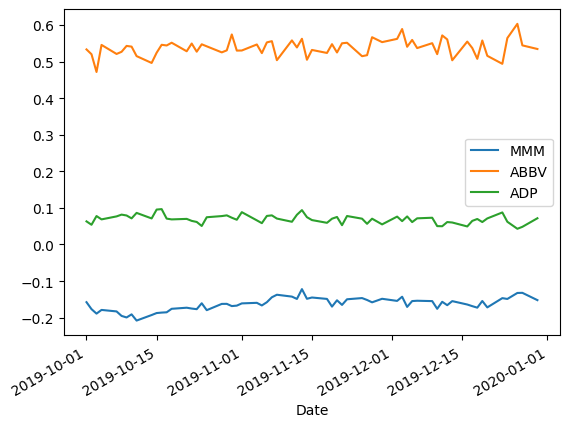

In [9]:
pred_mean_df[['MMM', 'ABBV', 'ADP']].plot()

In [10]:
minmax_scaled_data, minmax_f_scaler, minmax_t_scaler = ScaleData(stock_data, split_date=TEST_SPLITS[4], scaler=MinMaxScaler())

In [11]:
# minmax_t_scaler.inverse_transform(minmax_scaled_data.log_return_3m.values.reshape(-1,1)) - stock_data.log_return_3m.values.reshape(-1,1)
# minmax_t_scaler.transform(stock_data.log_return_3m.values.reshape(-1,1)) - stock_data.log_return_3m.values.reshape(-1,1)

scaler = MinMaxScaler()

feature_scaler = deepcopy(scaler)
target_scaler = deepcopy(scaler)

ticker_rows_train = stock_data.loc[stock_data.index < TEST_SPLITS[4]].copy()
ticker_rows_test = stock_data.loc[stock_data.index >= TEST_SPLITS[4]].copy()

feature_columns = ticker_rows_train.drop(columns=['Ticker', 'Sector']).columns
target_columns = ['log_return_3m']

ticker_rows_train[target_columns] = target_scaler.fit_transform(ticker_rows_train[target_columns])
ticker_rows_test[target_columns] = target_scaler.transform(ticker_rows_test[target_columns])

scaled_stock_data = pd.concat([ticker_rows_train, ticker_rows_test], axis=0)

In [12]:
minmax_scaled_data.log_return_3m[0], \
scaled_stock_data.log_return_3m[0], \
target_scaler.transform(stock_data.log_return_3m.values.reshape(-1,1))[0]

/zhome/55/d/147333/Desktop/bachelor/financial-forecasting-bachelor/.venv/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


(0.6316686406737628, 0.6316686406737628, array([0.63166864]))

In [13]:
stock_data.log_return_3m.values[0], \
scaled_stock_data.log_return_3m.values[0], \
target_scaler.inverse_transform(scaled_stock_data.log_return_3m.values.reshape(-1,1))[0], \
minmax_t_scaler.inverse_transform(scaled_stock_data.log_return_3m.values.reshape(-1,1))[0], \
scaled_stock_data.log_return_3m[0]

# ONLY this one is correct? its like the returned scaler doesnt do anything at all

(0.024965163,
 0.6316686406737628,
 array([0.02496516]),
 array([0.63166864]),
 0.6316686406737628)

In [15]:
df = pd.DataFrame({'val1': [10,22,30,39,50,60,70,80,90,100]})

In [18]:
df['return'] = df.val1.pct_change(5)
df['log'] = np.log(df.val1)
df['log_return'] = n_lag_return(df.log, lags=5)#.shift(-5)
df['return_2'] = LogReturn2SimpleReturn(df.log_return)
print(df)

   val1    return       log  log_return  return_2
0    10       NaN  2.302585         NaN       NaN
1    22       NaN  3.091042         NaN       NaN
2    30       NaN  3.401197         NaN       NaN
3    39       NaN  3.663562         NaN       NaN
4    50       NaN  3.912023         NaN       NaN
5    60  5.000000  4.094345    1.791759  5.000000
6    70  2.181818  4.248495    1.157453  2.181818
7    80  1.666667  4.382027    0.980829  1.666667
8    90  1.307692  4.499810    0.836248  1.307692
9   100  1.000000  4.605170    0.693147  1.000000


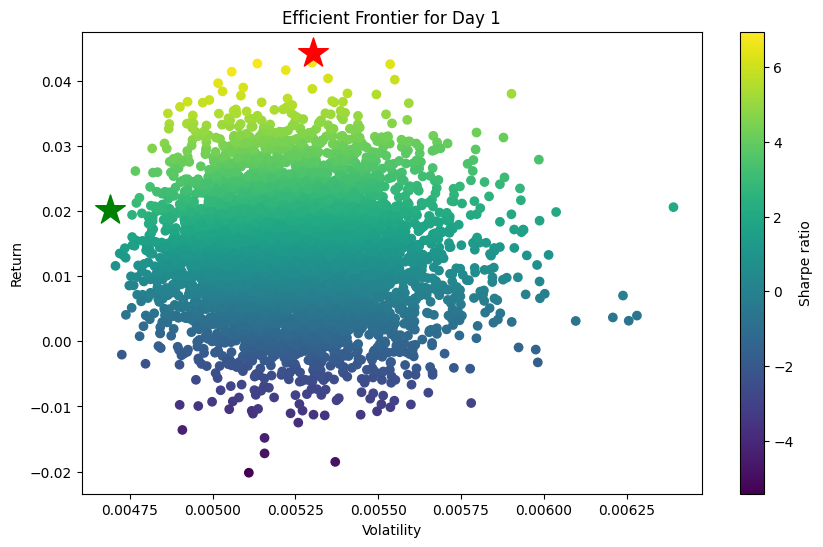

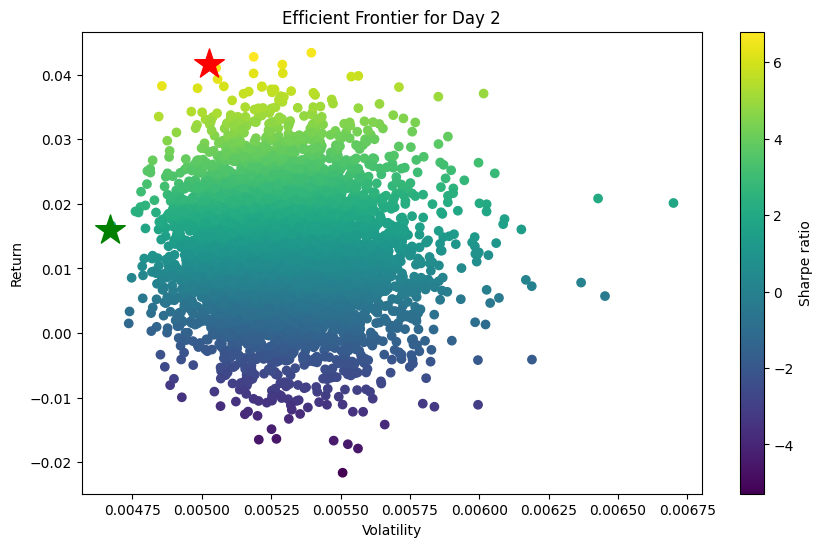

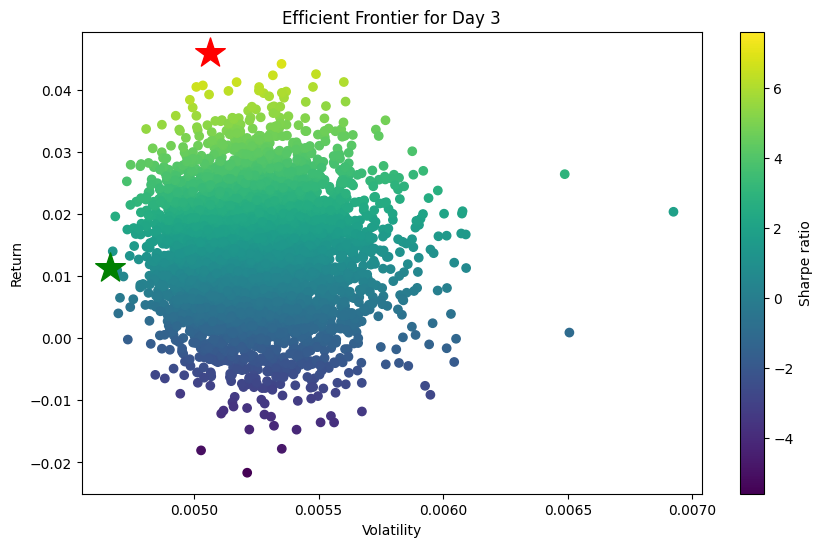

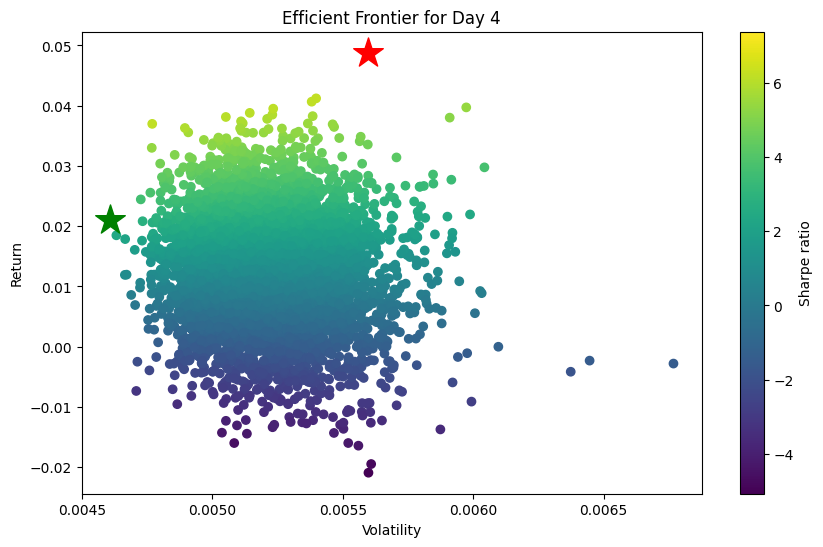

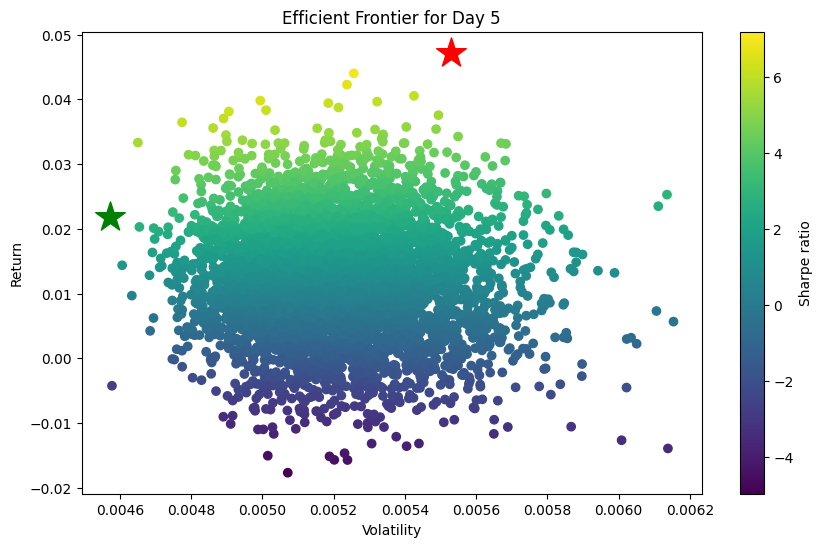

KeyboardInterrupt: 

In [11]:
# Your dataframes: df_returns for daily returns, df_stds for daily standard deviations
# They should have the same shape and share indices and columns
assert pred_mean_df.shape == pred_std_df.shape
assert (pred_mean_df.index == pred_std_df.index).all()
assert (pred_mean_df.columns == pred_std_df.columns).all()

# Set up an array to hold results
n_days, n_assets = pred_mean_df.shape

n_portfolios = 5000  # number of portfolios to simulate each day

# Run simulation for each day
for i in range(n_days):
    # Get mean returns and standard deviations for the day
    means = pred_mean_df.iloc[i].values
    stds = pred_std_df.iloc[i].values

    # Calculate the covariance matrix based on the predicted stds
    cov_matrix = np.diag(stds**2)

    # Arrays to store simulation results
    portfolio_returns = []
    portfolio_risks = []
    portfolio_weights = []
    portfolio_sharpe_ratios = []

    # Generate random portfolios
    for _ in range(n_portfolios):
        weights = np.random.dirichlet(np.ones(n_assets))  # generate random weights
        portfolio_weights.append(weights)

        # Calculate portfolio return and risk
        returns = np.dot(weights, means)
        portfolio_returns.append(returns)

        var = np.dot(weights.T, np.dot(cov_matrix, weights))
        portfolio_risks.append(np.sqrt(var))

        # Calculate Sharpe ratio
        sharpe_ratio = (returns - 0.03 / 4) / np.sqrt(var) # risk free rate in last quarter of 2019 was 3% - 0.03
        portfolio_sharpe_ratios.append(sharpe_ratio)

    # Convert to numpy arrays
    portfolio_returns = np.array(portfolio_returns)
    portfolio_risks = np.array(portfolio_risks)
    portfolio_weights = np.array(portfolio_weights)
    portfolio_sharpe_ratios = np.array(portfolio_sharpe_ratios)

    # Identify the portfolio with the highest Sharpe ratio
    max_index = np.argmax(portfolio_sharpe_ratios)
    optimal_risk = portfolio_risks[max_index]
    optimal_return = portfolio_returns[max_index]
    optimal_weights = portfolio_weights[max_index]

    # Plot the efficient frontier for the day
    plt.figure(figsize=(10, 6))
    plt.scatter(portfolio_risks, portfolio_returns, c=portfolio_sharpe_ratios, cmap='viridis', marker='o')
    plt.colorbar(label='Sharpe ratio')
    # plot the minimum volatility portfolio
    plt.scatter(portfolio_risks[np.argmin(portfolio_risks)], portfolio_returns[np.argmin(portfolio_risks)], color='g', marker='*', s=500) # min volatility portfolio
    plt.scatter(optimal_risk, optimal_return, color='r', marker='*', s=500)  # optimal portfolio
    # make efficient frontier line connecting min vol portfolio and optimal portfolio

    plt.xlabel('Volatility')
    plt.ylabel('Return')
    plt.title(f'Efficient Frontier for Day {i+1}')
    plt.show()

